In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import pyedflib

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import matplotlib.image as mpimg
from scipy.signal import hilbert, filtfilt, find_peaks, lfilter

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.inta_ss import IntaSS, NAMES, IDS_TEST
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection import metrics
from sleeprnn.data.loader import RefactorUnpickler
from sleeprnn.common import constants, pkeys

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 100
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

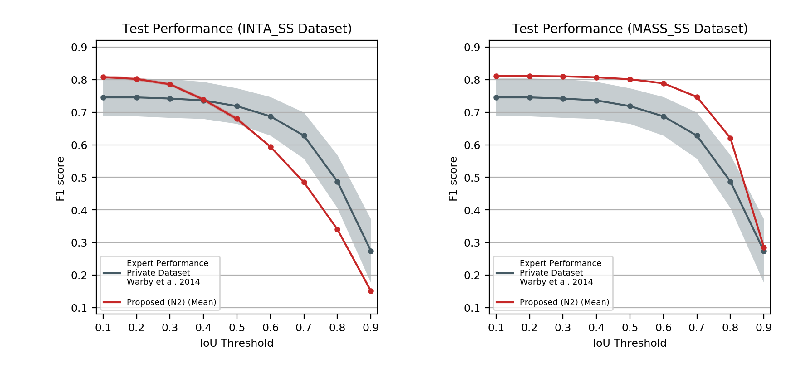

Train size: 7. Test size: 3
Train subjects: 
 [1, 2, 4, 6, 8, 10, 11]
Test subjects: 
 [5, 7, 9]
Dataset inta_ss with 10 patients.
Loading from checkpoint... Loaded
Global STD: 39.144096
Loaded seed 1/4 from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15/seed0
Loaded seed 2/4 from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15/seed1
Loaded seed 3/4 from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15/seed2
Loaded seed 4/4 from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15/seed3
Optimal thr: [0.42, 0.44, 0.48, 0.5]


In [2]:
# Show relevant plots
f1_inta_plot = mpimg.imread('/home/ntapia/Dropbox/Laboratorio IC/Reuniones Inta/20190705_meeting_inta/test_f1_inta.png')
f1_mass_plot = mpimg.imread('/home/ntapia/Dropbox/Laboratorio IC/Reuniones Inta/20190705_meeting_inta/test_f1_mass.png')
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=DPI)
ax[0].imshow(f1_inta_plot)
ax[1].imshow(f1_mass_plot)
for single_ax in ax:
    single_ax.axis('off')
plt.tight_layout()
plt.show()

# Load dataset
dataset = IntaSS(load_checkpoint=True, params={pkeys.NORM_COMPUTATION_MODE: constants.NORM_GLOBAL})
dataset_name = constants.INTA_SS_NAME

# Load predictions
ckpt_folder = os.path.join('20190706_inta_05_n2_train_inta_ss', 'v15')
optimal_thr_list = [0.42, 0.44, 0.48, 0.5]
task_mode = constants.N2_RECORD
seed_id_list = [0, 1, 2, 3]
n_seeds = len(seed_id_list)
set_list = [constants.TRAIN_SUBSET, constants.VAL_SUBSET, constants.TEST_SUBSET]
which_expert = 1
verbose = False
predictions_dict = {}
for k in seed_id_list:
    # Restore predictions
    ckpt_path = os.path.abspath(os.path.join(
        RESULTS_PATH,
        'predictions_%s' % dataset_name,
        ckpt_folder,
        'seed%d' % k
    ))
    this_dict = {}
    for set_name in set_list:
        filename = os.path.join(
                ckpt_path,
                'prediction_%s_%s.pkl' % (task_mode, set_name))
        with open(filename, 'rb') as handle:
            this_pred = RefactorUnpickler(handle).load()
        this_dict[set_name] = this_pred
    predictions_dict[k] = this_dict
    print('Loaded seed %d/%d from %s' % (k + 1, n_seeds, ckpt_path))
print('Optimal thr:', optimal_thr_list)

In [76]:
# Load stamps of subject
subject_id = 11  # 4, 11

print('Loading S%02d' % subject_id)
fs = dataset.fs
path_dataset = dataset.dataset_dir
path_stamps = os.path.join(path_dataset, 'label/spindle', 'SS_%s.txt' % NAMES[subject_id - 1])
path_signals = os.path.join(path_dataset, 'register', '%s.rec' % NAMES[subject_id - 1]) 

with pyedflib.EdfReader(path_signals) as file:
    signal = file.readSignal(0)
    channel_name = file.getLabel(0)
    print('Reading', channel_name)
    signal_len = signal.shape[0]
data = np.loadtxt(path_stamps)
for_this_channel = (data[:, -1] == 1)
data = data[for_this_channel]
data = np.round(data).astype(np.int32)

# Remove zero duration marks, and ensure that start time < end time
new_data = []
for i in range(data.shape[0]):
    if data[i, 0] > data[i, 1]:
        print('End time < Start time fixed')
        aux = data[i, 0]
        data[i, 0] = data[i, 1]
        data[i, 1] = aux
        new_data.append(data[i, :])
    elif data[i, 0] < data[i, 1]:
        new_data.append(data[i, :])
    else:  # Zero duration (equality)
        print('Zero duration stamp found and removed')
data = np.stack(new_data, axis=0)

# Remove stamps outside signal boundaries
new_data = []
for i in range(data.shape[0]):
    if data[i, 1] < signal_len:
        new_data.append(data[i, :])
    else:
        print('Stamp outside boundaries found and removed')
data = np.stack(new_data, axis=0)

# Remove marks with duration less than min_samples
min_samples = 20
new_data = []
for i in range(data.shape[0]):
    if data[i, 1] - data[i, 0] >= min_samples:
        new_data.append(data[i, :])
    else:
        print('Stamp with too few samples removed')
data = np.stack(new_data, axis=0)

raw_stamps = data[:, [0, 1]]
valid = data[:, 4]
raw_stamps_0 = raw_stamps[valid == 0]
raw_stamps_1 = raw_stamps[valid == 1]
raw_stamps_2 = raw_stamps[valid == 2]
print(
    'Valid 0', raw_stamps_0.shape, 'Min dur [s]', (raw_stamps_0[:, 1] - raw_stamps_0[:, 0]).min()/fs, 
    'Max dur [s]', (raw_stamps_0[:, 1] - raw_stamps_0[:, 0]).max()/fs)
print(
    'Valid 1', raw_stamps_1.shape, 'Min dur [s]', (raw_stamps_1[:, 1] - raw_stamps_1[:, 0]).min()/fs, 
    'Max dur [s]', (raw_stamps_1[:, 1] - raw_stamps_1[:, 0]).max()/fs)
print(
    'Valid 2', raw_stamps_2.shape, 'Min dur [s]', (raw_stamps_2[:, 1] - raw_stamps_2[:, 0]).min()/fs, 
    'Max dur [s]', (raw_stamps_2[:, 1] - raw_stamps_2[:, 0]).max()/fs)

del raw_stamps_0

# look for intersections between stamps of the same validity
def overlap_matrix(events, detections):
    # Matrix of overlap, rows are events, columns are detections
    n_det = detections.shape[0]
    n_gs = events.shape[0]
    overlaps = np.zeros((n_gs, n_det))
    for i in range(n_gs):
        candidates = np.where(
            (detections[:, 0] <= events[i, 1])
            & (detections[:, 1] >= events[i, 0]))[0]
        for j in candidates:
            intersection = min(
                events[i, 1], detections[j, 1]
            ) - max(
                events[i, 0], detections[j, 0]
            ) + 1
            if intersection > 0:
                overlaps[i, j] = 1
    return overlaps

def overlapping_groups(overlap_matrix):
    groups_overlap = [[0]]
    for i in range(overlap_matrix.shape[0]):
        visited = np.any([i in single_group for single_group in groups_overlap])
        if not visited:
            # Check if intersects with an existent group
            added = False
            for single_group in groups_overlap:
                is_overlapping = np.any(overlap_matrix[i, single_group])
                if is_overlapping:
                    single_group.append(i)
                    added = True
            if not added:
                # Then variable is a new group
                groups_overlap.append([i])
    return groups_overlap

overlap_m = overlap_matrix(raw_stamps_1, raw_stamps_1)
groups_overlap_1 = overlapping_groups(overlap_m)

n_overlaps_1 = [len(single_group) for single_group in groups_overlap_1]
values_1, counts_1 = np.unique(n_overlaps_1, return_counts=True)
print('\nSize of overlapping groups for Valid 1')
for value, count in zip(values_1, counts_1):
    print('%d marks: %d times' % (value, count))

overlap_m = overlap_matrix(raw_stamps_2, raw_stamps_2)
groups_overlap_2 = overlapping_groups(overlap_m)
n_overlaps_2 = [len(single_group) for single_group in groups_overlap_2]
values_2, counts_2 = np.unique(n_overlaps_2, return_counts=True)
print('\nSize of overlapping groups for Valid 2')
for value, count in zip(values_2, counts_2):
    print('%d marks: %d times' % (value, count))

max_overlaps_1 = values_1.max() - 1
max_overlaps_2 = values_2.max() - 1
max_overlaps = np.max([max_overlaps_1, max_overlaps_2])

Loading S11
Reading F4-C4
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
Zero duration stamp found and removed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
Stamp with too few samples removed
Stamp with too few samples removed
Stamp with too few samples removed
Stamp with too few samples removed
Stamp with too few samples removed
Stamp with too few samples removed
Valid 0 (4932, 2) Min dur [s] 0.305 Max dur [s] 29.87
Valid 1 (1252, 2) Min dur [s] 0.26 Max dur [s] 5.555
Valid 2 (1303, 2) Min dur [s] 0.1 Max dur [s] 4.86

Size of overlapping groups for Valid 1
1 marks: 1248 times
2 marks: 2 times

Size of overlapping groups for Valid 2
1 marks: 438 times
2 marks: 233 times
3 marks: 65 times
4 marks: 33 times
5 marks: 12 times
6 marks: 2 times


In [108]:
# Signal
signal_dict = {}
fs_dict = {}
with pyedflib.EdfReader(path_signals) as file:
    signal_names = file.getSignalLabels()
    
print(signal_names)
eeg_names = signal_names[:5]
other_names = signal_names[5:7] #  + signal_names[7:8]
to_show_names = eeg_names + other_names
print(to_show_names)  

['F4-C4', 'C4-O2', 'F3-C3', 'C3-O1', 'C4-C3', 'MOR', 'EMG', 'MOV-SUP', 'MOV-INF', 'ECG', 'RESP-NASAL', 'RESP-ABD', 'TEMPERATURA', 'PULSO', 'SAO2', 'POSICION']
['F4-C4', 'C4-O2', 'F3-C3', 'C3-O1', 'C4-C3', 'MOR', 'EMG']


In [ ]:
with pyedflib.EdfReader(path_signals) as file:   
    for k, name in enumerate(signal_names):
        if name in to_show_names:
            this_signal = file.readSignal(k)
            fs_dict[name] = file.getSampleFrequency(k)
            
            if name in eeg_names:
                this_signal = utils.broad_filter(this_signal, fs_dict[name])
            
            signal_dict[name] = this_signal

In [6]:
# -*- coding: utf-8 -*-
# -*- mode: python -*-
# Adapted from mpl_toolkits.axes_grid1
# LICENSE: Python Software Foundation (http://docs.python.org/license.html)

from matplotlib.offsetbox import AnchoredOffsetbox
class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, sizex=0, sizey=0, labelx=None, labely=None, loc=4,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, barcolor="black", barwidth=None, 
                 **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea, DrawingArea
        bars = AuxTransformBox(transform)
        if sizex:
            bars.add_artist(Rectangle((0,0), sizex, 0, ec=barcolor, lw=barwidth, fc="none"))
        if sizey:
            bars.add_artist(Rectangle((0,0), 0, sizey, ec=barcolor, lw=barwidth, fc="none"))

        if sizex and labelx:
            self.xlabel = TextArea(labelx, minimumdescent=False)
            bars = VPacker(children=[bars, self.xlabel], align="center", pad=0, sep=sep)
        if sizey and labely:
            self.ylabel = TextArea(labely)
            bars = HPacker(children=[self.ylabel, bars], align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)

        
def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """ Add scalebars to axes
    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes
    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars
    Returns created scalebar object
    """
    def f(axis):
        l = axis.get_majorticklocs()
        return len(l)>1 and (l[1] - l[0])
    
    if matchx:
        kwargs['sizex'] = f(ax.xaxis)
        kwargs['labelx'] = str(kwargs['sizex'])
    if matchy:
        kwargs['sizey'] = f(ax.yaxis)
        kwargs['labely'] = str(kwargs['sizey'])
        
    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex : ax.xaxis.set_visible(False)
    if hidey : ax.yaxis.set_visible(False)
    if hidex and hidey: ax.set_frame_on(False)

    return sb

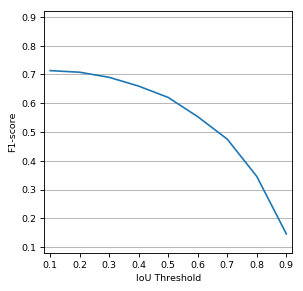

In [77]:
subject_seed_set_dict = {
    1: (2, constants.VAL_SUBSET),
    2: (1, constants.VAL_SUBSET),
    4: (0, constants.VAL_SUBSET),
    5: (0, constants.TEST_SUBSET),
    6: (1, constants.VAL_SUBSET),
    7: (0, constants.TEST_SUBSET),
    8: (3, constants.VAL_SUBSET),
    9: (0, constants.TEST_SUBSET),
    10: (2, constants.VAL_SUBSET),
    11: (0, constants.VAL_SUBSET),
}

this_pages = dataset.get_subject_pages(subject_id=subject_id) 
this_stamps = dataset.get_subject_stamps(subject_id=subject_id)

# Model predictions
model_stamps_list = []
iou_list = np.arange(1, 10) * 0.1
f1_vs_iou_list = []
this_seed = subject_seed_set_dict[subject_id][0]
set_name = subject_seed_set_dict[subject_id][1]
prediction_obj = predictions_dict[this_seed][set_name]
prediction_obj.set_probability_threshold(optimal_thr_list[this_seed])
this_detections = prediction_obj.get_subject_stamps(subject_id=subject_id)
model_stamps_list.append(this_detections)
f1_vs_iou = metrics.metric_vs_iou(
    this_stamps, this_detections, iou_list)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=80)
ax.plot(iou_list, f1_vs_iou)
ax.set_xlim([0.1 - 0.02, 0.9 + 0.02])
ax.set_ylim([0.1 - 0.02, 0.9 + 0.02])
ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks([0.1*i for i in range(1, 10)])
ax.tick_params(labelsize=8.5)
ax.set_xlabel('IoU Threshold', fontsize=8.5)
ax.set_ylabel('F1-score', fontsize=8.5)
ax.yaxis.grid()
plt.show()

In [172]:
model_stamps_color = CUSTOM_COLOR['blue']
expert_stamps_color = CUSTOM_COLOR['red']
stamps_color = '#B71C1C'

def filter_stamps(stamps, start_sample, end_sample):
    useful_idx = np.where((stamps[:, 0] >= start_sample) & (stamps[:, 1] <= end_sample))[0]
    useful_stamps = stamps[useful_idx, :]
    return useful_stamps

def plot_page(page_chosen, show_model, show_expert, dpi=DPI):
    
    microvolt_per_second = 200  # Aspect ratio
    
    fig = plt.figure(figsize=(12, 0.7*len(to_show_names)+2), dpi=dpi)
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 2, 3*len(to_show_names)])
    
    page_start = page_chosen * dataset.page_size
    page_end = page_start + dataset.page_size
    
    if show_expert:
        segment_stamps = filter_stamps(this_stamps, page_start, page_end)
        segment_stamps_valid_1 = filter_stamps(raw_stamps_1, page_start, page_end)
        segment_stamps_valid_2 = filter_stamps(raw_stamps_2, page_start, page_end)
    else:
        segment_stamps = []
        segment_stamps_valid_1 = []
        segment_stamps_valid_2 = []
        
    segment_model_stamps = []
    for single_stamps in model_stamps_list:
        if show_model:
            segment_single_stamps = filter_stamps(single_stamps, page_start, page_end)
            segment_model_stamps.append(segment_single_stamps)
        else:
            segment_model_stamps.append([])
    
    time_axis = np.arange(page_start, page_end) / fs
    x_ticks = time_axis[0] + np.arange(5, 21, 5)
    
    gs_idx = 0

    # Show valid 1
    delta_y = 0.1
    ax = fig.add_subplot(gs[gs_idx])
    shown_groups_1 = []
    for j, this_stamp in enumerate(segment_stamps_valid_1):
        idx_stamp = np.where([np.all(this_stamp == single_stamp) for single_stamp in raw_stamps_1])[0]
        idx_group = np.where([idx_stamp in single_group for single_group in groups_overlap_1])[0][0].item()
        shown_groups_1.append(idx_group)
        n_stamps = len(segment_stamps_valid_1)
        dy_for_stamp = 1/n_stamps
        ax.plot(this_stamp/fs, [j*dy_for_stamp, j*dy_for_stamp], color=stamps_color, linewidth=1.5)
    center_list = []
    size_list = []
    name_group_list = []
    shown_groups_1 = np.unique(shown_groups_1)
    for single_group in shown_groups_1:
        group_stamps = [raw_stamps_1[single_idx] for single_idx in groups_overlap_1[single_group]]
        group_stamps = np.stack(group_stamps, axis=0)
        coverage = [group_stamps.min(), group_stamps.max()]
        center_list.append(np.mean(coverage) / fs)
        size_list.append(group_stamps.size)
        name_group_list.append('idx-%d' % single_group)
    
    ax.set_xticks(center_list)
    ax.set_xticklabels(name_group_list, fontsize=8)
    ax.set_yticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylabel('V1', fontsize=8)
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    
    # Show valid 2
    delta_y = 0.1
    gs_idx = gs_idx + 1
    ax = fig.add_subplot(gs[gs_idx])
    shown_groups_2 = []
    for j, this_stamp in enumerate(segment_stamps_valid_2):
        idx_stamp = np.where([np.all(this_stamp == single_stamp) for single_stamp in raw_stamps_2])[0]
        idx_group = np.where([idx_stamp in single_group for single_group in groups_overlap_2])[0][0].item()
        shown_groups_2.append(idx_group)
        n_stamps = len(segment_stamps_valid_2)
        dy_for_stamp = 1/n_stamps
        ax.plot(this_stamp/fs, [j*dy_for_stamp, j*dy_for_stamp], color=stamps_color, linewidth=1.5)
    center_list = []
    size_list = []
    name_group_list = []
    shown_groups_2 = np.unique(shown_groups_2)
    for single_group in shown_groups_2:
        group_stamps = [raw_stamps_2[single_idx] for single_idx in groups_overlap_2[single_group]]
        group_stamps = np.stack(group_stamps, axis=0)
        coverage = [group_stamps.min(), group_stamps.max()]
        center_list.append(np.mean(coverage) / fs)
        size_list.append(group_stamps.size)
        name_group_list.append('idx-%d' % single_group)
    
    ax.set_xticks(center_list)
    ax.set_xticklabels(name_group_list, fontsize=8)
    ax.set_yticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylabel('V2', fontsize=8)
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    
    # Signal
    gs_idx = gs_idx + 1
    y_max = 150
    y_sep = 200
    ax = fig.add_subplot(gs[gs_idx])
    
    for k, name in enumerate(to_show_names):
        if name == 'F4-C4':
            stamp_center = -y_sep*k
        segment_fs = fs_dict[name]
        segment_start = int(page_chosen * dataset.page_duration * segment_fs)
        segment_end = int(segment_start + dataset.page_duration * segment_fs)
        segment_signal = signal_dict[name][segment_start:segment_end]
        segment_time_axis = np.arange(segment_start, segment_end) / segment_fs
        ax.plot(
            segment_time_axis, -y_sep*k + segment_signal, linewidth=1, color=CUSTOM_COLOR['grey'])
    
    add_scalebar(ax, matchx=False, matchy=False, hidex=False, hidey=False, sizex=1, sizey=100, labelx='1 s', labely='100 uV')
    model_shown = False
    expert_shown = False
    primitive_shown = False
    for single_segment_model_stamps in segment_model_stamps:
        for model_stamp in single_segment_model_stamps:
            if not model_shown:
                label = 'Model'
            else:
                label = None
            ax.fill_between(
                model_stamp / fs, 50+stamp_center, -50+stamp_center, 
                facecolor=model_stamps_color, alpha=0.5,  label=label)
            model_shown = True
    for expert_stamp in segment_stamps:
        if not expert_shown:
            label = 'Expert'
        else:
            label = None
        ax.plot(
            expert_stamp / fs, [stamp_center-50, stamp_center-50], 
            color=expert_stamps_color, linewidth=2, label=label)
        expert_shown = True
    
    ax.set_yticks([-y_sep*k for k in range(len(to_show_names))])
    ax.set_yticklabels(to_show_names)
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylim([-y_max -y_sep*(len(to_show_names)-1) - 30, y_max])
    ax.set_title('Subject %d (%s INTA). Page in record: %1.1f. (intervals of 0.5s are shown).' 
                 % (subject_id, NAMES[subject_id-1], page_chosen), fontsize=10)
    ax.set_xticks(x_ticks)
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=8.5)
    ax.set_aspect(1/microvolt_per_second)
    ax.set_xlabel('Time [s]', fontsize=8)

    if model_shown or expert_shown:
        lg = ax.legend(loc='upper right', fontsize=8)
        for lh in lg.legendHandles:
            lh.set_alpha(1.0)
    
    plt.tight_layout()
    plt.show()

In [173]:
size_range = [4,4]

print('Overlapping groups for Valid 1 with size %s' % size_range)
to_print_list = [sub_group for sub_group in groups_overlap_1 if len(sub_group)>=size_range[0] and len(sub_group)<=size_range[1]]
cases_v1_list = []
for single_group in to_print_list:
    idx_group = groups_overlap_1.index(single_group)
    integer_page = int(raw_stamps_1[single_group[0], :].mean() / dataset.page_size)
    decimal_part = np.round(2 * (raw_stamps_1[single_group[0], :].mean() % dataset.page_size) / dataset.page_size) / 2 - 0.5
    single_page = integer_page + decimal_part
    cases_v1_list.append(single_page)
    print('Group size %d. Page in record: %1.1f. Group: %s' % (len(single_group), single_page, single_group))
print('')
print('Overlapping groups for Valid 2 with size %s' % size_range)
to_print_list = [sub_group for sub_group in groups_overlap_2 if len(sub_group)>=size_range[0] and len(sub_group)<=size_range[1]]
cases_v2_list = []
for single_group in to_print_list:
    idx_group = groups_overlap_2.index(single_group)
    integer_page = int(raw_stamps_2[single_group[0], :].mean() / dataset.page_size)
    decimal_part = np.round(2 * (raw_stamps_2[single_group[0], :].mean() % dataset.page_size) / dataset.page_size) / 2 - 0.5
    single_page = integer_page + decimal_part
    cases_v2_list.append(single_page)
    print('Group size %d. Page in record: %1.1f. Group: %s' % (len(single_group), single_page, single_group))
    
cases_v1_list = np.unique(cases_v1_list)
cases_v2_list = np.unique(cases_v2_list)

Overlapping groups for Valid 1 with size [4, 4]

Overlapping groups for Valid 2 with size [4, 4]
Group size 4. Page in record: 349.0. Group: [113, 114, 115, 116]
Group size 4. Page in record: 394.0. Group: [180, 181, 182, 183]
Group size 4. Page in record: 394.5. Group: [184, 185, 186, 187]
Group size 4. Page in record: 400.5. Group: [198, 199, 200, 201]
Group size 4. Page in record: 401.0. Group: [205, 206, 207, 208]
Group size 4. Page in record: 403.0. Group: [217, 218, 219, 220]
Group size 4. Page in record: 405.5. Group: [226, 227, 228, 229]
Group size 4. Page in record: 409.5. Group: [253, 254, 255, 256]
Group size 4. Page in record: 411.5. Group: [263, 264, 265, 266]
Group size 4. Page in record: 414.0. Group: [275, 276, 277, 278]
Group size 4. Page in record: 415.5. Group: [286, 287, 288, 289]
Group size 4. Page in record: 425.0. Group: [324, 325, 326, 327]
Group size 4. Page in record: 429.0. Group: [342, 343, 344, 345]
Group size 4. Page in record: 432.5. Group: [361, 362, 363

In [174]:
print('%s v2 cases. %d v1 cases' % (len(cases_v2_list), len(cases_v1_list)))


start_page = cases_v2_list[2]
# s11 394 muy rapido, 415 muy lento, 204
# s4 62 289 364 408 616.5 625 640 847 864.5 879.5 924 939 1009
show_model = False
show_expert = True

style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda page_chosen: plot_page(page_chosen, show_model, show_expert, dpi=100),
    page_chosen=widgets.FloatSlider(
        min=this_pages.min(), max=this_pages.max(), step=0.5, value=start_page, 
        continuous_update=False,
        style=style,
        layout=layout
    ));

33 v2 cases. 0 v1 cases


interactive(children=(FloatSlider(value=394.5, continuous_update=False, description='page_chosen', layout=Layo…

In [ ]:
"""
TODO:
mostrar V1 y V2 en el mismo cuadrado de plot al principio, para que sea mas facil la comparacion. Los V1 que sean azules. Los V2 que sean rojos.
marcas  aceptadas se pintaran de verde y se dibujaran sobre la señal con verde y un cuadrado transparente. No mostrar marca elegida actualmente.
Asignar id a marcas por sujeto: Diccionario de sujetos, donde cada sujeto posee una lista de marcas validadas. Las marcas V1 seran 10000 + idx; 
las marcas V2 seran 20000 + idx. Pensar forma de moistrar este indice en pantalla sin que se vea muy sucio. Idea: mantener constante el spacing entre 
rayas V1 y V2 de forma que quepa el texto del ID a la izquierda.
Crear una lista que maneje

"""

